SST-5 (Stanford Sentiment Treebank 5-class) là một tập dữ liệu phổ biến trong lĩnh vực xử lý ngôn ngữ tự nhiên (NLP), dùng để phân loại cảm xúc của câu văn dựa trên mức độ cảm xúc. Đây là phiên bản mở rộng của Stanford Sentiment Treebank, nơi mà dữ liệu được dán nhãn thành 5 cấp độ cảm xúc:

Rất tiêu cực (Very Negative)
Tiêu cực (Negative)
Trung lập (Neutral)
Tích cực (Positive)
Rất tích cực (Very Positive)
Dữ liệu trong SST-5 bao gồm các câu tiếng Anh đã được gán nhãn với một trong năm mức độ cảm xúc này, giúp các mô hình học máy học cách phân loại cảm xúc phức tạp hơn so với chỉ có hai lớp (tích cực và tiêu cực).

Nội dung của bài thực hành này là kết hợp các kiến thức đã được học trong khóa NLP để xây dựng mô hình phân loại đa nhãn cho bài toán này.

Mục tiêu chính là sử dụng CNN trong kiến trúc chính, ngoài ra những phần khác có thể cấu hình theo ý tưởng cá nhân để nâng cao hiệu quả mô hình (bao gồm lựa chọn thư viện, phương pháp tiền xử lý, lựa chọn biểu diễn nhúng huấn luyện trước....)

Kiến trúc của notebook này được phân loại thành  phần chính như sau:
- Import thư viện và data
- Tiền xử lý dữ liệu
- Embedding text to vector
- Build model
- Evaluate model


In [1]:
# # train set
# !gdown 1pd5HE6KdE4CjdYarUpHqM2da75LxjigB
# # dev set
# !gdown 1LfvEzKBlr3tVzG6yFNTcxmB3rNVVRzm1
# # test set
# !gdown 1Uk8cTWvnmPrxMIu5h6IIA7qqqcO36Von

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !pip install nltk
# !pip install pandas


In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Embedding, Dropout
from tensorflow.keras.optimizers import Adam

# Tải từ điển stopwords và bộ tokenization của NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


2024-10-28 16:21:58.424603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 16:21:58.513026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 16:21:58.543339: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 16:21:58.753312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 16:22:00.276035: W tensorflow/compiler/tf2

True

In [5]:
import json
#import dữ liệu
######  YOUR CODE HERE ######
# Đọc tệp train.jsonl
with open('train.jsonl', 'r') as f:
    train_data = [json.loads(line) for line in f]

# Đọc tệp dev.jsonl
with open('dev.jsonl', 'r') as f:
    dev_data = [json.loads(line) for line in f]

# Đọc tệp test.jsonl
with open('test.jsonl', 'r') as f:
    test_data = [json.loads(line) for line in f]


# Tạo DataFrame từ danh sách data
df_train = pd.DataFrame(train_data)
df_dev = pd.DataFrame(dev_data)
df_test = pd.DataFrame(test_data)

######  YOUR CODE HERE ######


In [6]:
df_train.head()

,text,label,label_text
0,"a stirring , funny and finally transporting re...",4,very positive
1,apparently reassembled from the cutting-room f...,1,negative
2,they presume their audience wo n't sit still f...,1,negative
3,the entire movie is filled with deja vu moments .,2,neutral
4,this is a visually stunning rumination on love...,3,positive


# Xây dựng các hàm xử lý văn bản

## Hàm loại bỏ ký tự đặc biệt và số

In [7]:
def remove_special_characters(text):
  #### YOUR CODE HERE ######
  # Loại bỏ ký tự không phải chữ cái và số
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  return text

## Hàm chuyển văn bản thành chữ thường

In [8]:
def to_lower(text):
    
    text = text.lower()
    return text

## Hàm tách từ (Tokenization)

In [9]:
def tokenize(text):
    #### YOUR CODE HERE ######
    # Tách từ (tokenize)
    tokens = word_tokenize(text)
    return tokens


## Hàm Stemming (Đưa từ về dạng gốc - Porter Stemmer)

In [10]:
ps = PorterStemmer()

def stem_words(text):
    # Stem các từ trong văn bản
    stemmed_words = []
    for word in text:
        stemmed_words.append(ps.stem(word))
    return ' '.join(stemmed_words)

sample_text = "This is a sample sentence, with numbers like 123 and special characters like @#!."
print(stem_words(sample_text.split()))


thi is a sampl sentence, with number like 123 and special charact like @#!.


## Áp dụng các hàm xử lý văn bản

In [11]:
def preprocess_text(text):
    # Loại bỏ ký tự đặc biệt
    text = remove_special_characters(text)
    # Chuyển thành chữ thường
    text = to_lower(text)
    # Đưa từ về dạng gốc (có thể thay bằng lemmatize_words nếu bạn muốn dùng Lemmatization)
    text = stem_words(text.split())
    return text

# Ví dụ áp dụng cho một đoạn văn bản
sample_text = "This is a sample sentence, with numbers like 123 and special characters like @#!."
processed_text = preprocess_text(sample_text)
print(processed_text)


thi is a sampl sentenc with number like 123 and special charact like


In [25]:
# Xử lý văn bản cho 3 tập train- dev - test

# Giả sử df là DataFrame của bạn và cột 'text' chứa dữ liệu văn bản
df_train['processed_text'] = df_train['text'].apply(preprocess_text) #### YOUR CODE HERE
df_test['processed_text'] =  df_test['text'].apply(preprocess_text) #### YOUR CODE HERE
df_dev['processed_text'] =  df_dev['text'].apply(preprocess_text) #### YOUR CODE HERE

print(df_train[['text', 'processed_text']].head())


                                                text  \
0  a stirring , funny and finally transporting re...   
1  apparently reassembled from the cutting-room f...   
2  they presume their audience wo n't sit still f...   
3  the entire movie is filled with deja vu moments .   
4  this is a visually stunning rumination on love...   

                                      processed_text  
0  a stir funni and final transport reimagin of b...  
1  appar reassembl from the cuttingroom floor of ...  
2  they presum their audienc wo nt sit still for ...  
3         the entir movi is fill with deja vu moment  
4  thi is a visual stun rumin on love memori hist...  


# Embedding Text
Sử dụng phương pháp phù hợp sẽ giúp kết quả mô hình tăng hiệu quả


In [26]:
## Sử dụng các phương pháp để chuyển đổi text thành các vector
#### YOUR CODE HERE
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features
vectorizer.fit(df_train['processed_text'])
X_train = vectorizer.transform(df_train['processed_text']).toarray()
X_dev = vectorizer.transform(df_dev['processed_text']).toarray()
X_test = vectorizer.transform(df_test['processed_text']).toarray()

# Xây dựng mô hình


## Chuẩn bị dữ liệu đầu vào

In [27]:
# Chuyển đổi định dạng để phù hợp với input của CNN (thêm chiều thứ 3)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = df_train['label'].values

X_dev = X_dev.reshape(X_dev.shape[0], X_dev.shape[1], 1)
y_dev = df_dev['label'].values

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = df_test['label'].values

In [28]:
print(X_train.shape)

(8544, 5000, 1)


## Xây dựng mô hình CNN
Xây dựng kiến trúc mô hình CNN phù hợp để có thể sử dụng được cho bài toán phân loại đa nhãn

Kiến trúc của mô hình yêu cầu theo các tầng layer sau: Embedding -> [Conv -> Pooling] -> Fully connected

In [29]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/home/giabao/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 4996, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2498, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 79936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     2,557,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,558,341 (9.76 MB)

 Trainable params: 2,558,341 (9.76 MB)

 Non-trainable params: 0 (0.00 B)

# Huẩn luyện mô hình

In [30]:

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_dev, y_dev))

Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.2737 - loss: 1.5645 - val_accuracy: 0.3706 - val_loss: 1.4221
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4433 - loss: 1.3208 - val_accuracy: 0.3896 - val_loss: 1.3729
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5323 - loss: 1.1323 - val_accuracy: 0.3787 - val_loss: 1.3794
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6042 - loss: 0.9827 - val_accuracy: 0.3797 - val_loss: 1.4592
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6548 - loss: 0.8600 - val_accuracy: 0.3806 - val_loss: 1.5257
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.7054 - loss: 0.7494 - val_accuracy: 0.3624 - val_loss: 1.6441
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.7217 - loss: 0.6808 - val_accuracy: 0.3660 - val_loss: 1.7335
Epoch 8/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7616 - loss: 0.5928 - 

# Đánh giá mô hình

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
Accuracy: 0.4095


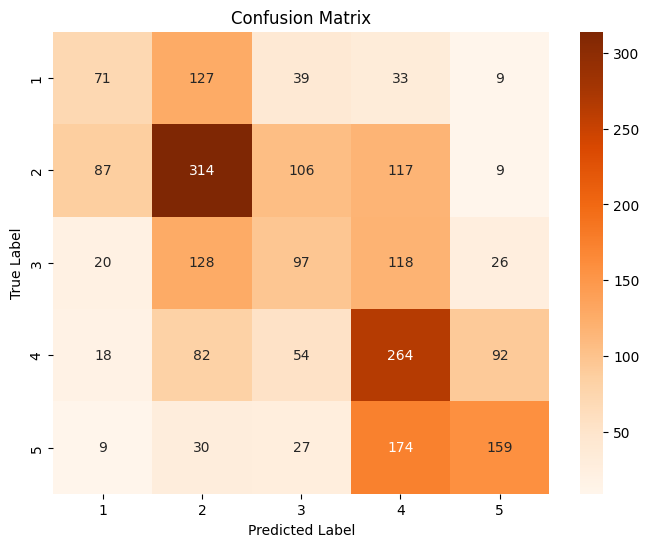

In [31]:

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=['1', '2', '3', '4', '5'],
            yticklabels=['1', '2', '3', '4', '5'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


